In [469]:
import numpy as np
import networkx as nx
import string
import matplotlib.pyplot as plt

np_map = np.loadtxt("simple-map-dungeon.txt").astype(int)
np_map

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0,

## Graph creation

In [470]:
G=nx.Graph()

for y in range(np_map.shape[0]):
    for x in range(np_map.shape[1]):
        if np_map[y,x]:
            continue
        
        if y+1 < np_map.shape[0] and np_map[y+1,x] == 0:
            G.add_edge((y,x),(y+1,x))
        
        if y-1 >= 0 and  np_map[y-1,x] == 0:
            G.add_edge((y,x),(y-1,x))
        
        if x+1 < np_map.shape[1] and  np_map[y,x+1] == 0:
            G.add_edge((y,x),(y,x+1))
        
        if x-1 >= 0 and  np_map[y,x-1] == 0:
            G.add_edge((y,x),(y,x-1))
        

In [471]:
paths = nx.shortest_path(G)

## 10.2 - K-medoids clustering

In [474]:
import random

klusters_n = 4
centroids = []

def get_dist_graph(G, v1, v2):
    return len(paths[v1][v2])

for i in range(klusters_n):
    centroids.append(random.choice(list(G.nodes())))

print(centroids)
    
for epoch in range(50):
    clusters = [set() for _ in range(len(centroids))]
    # Loop over the nodes
    for node in G.nodes():
        # Get closest distance to centroid i
        
        min_dist = np.inf
        min_centr = ()
        
        for centr in centroids:
            dist = get_dist_graph(G, node, centr)
            # Save min centroid
            if dist < min_dist:
                min_dist = dist
                min_centr = centr
        
        # Add node to correct cluster
        idx = centroids.index(min_centr)
        clusters[idx].add(node)

    for idx, clust_set in enumerate(clusters):
        min_dist = np.inf
        min_centr = ()
        for node in clust_set:
            sum_dist = sum(get_dist_graph(G, node, node2) for node2 in clust_set)
            if sum_dist < min_dist:
                min_dist = sum_dist
                min_centr = node

        centroids[idx] = min_centr    
print(centroids)        

[(14, 7), (11, 19), (16, 20), (4, 16)]
[(14, 5), (9, 18), (18, 15), (2, 6)]


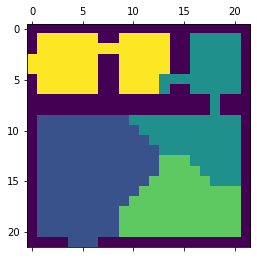

In [475]:
map_clustered = np_map.copy()
for y in range(np_map.shape[0]):
    for x in range(np_map.shape[1]):
        node = np_map[y,x]
        if node == 0:
            for idx, clust_set in enumerate(clusters):
                if (y,x) in clust_set:
                    map_clustered[y, x] = idx + 1
        else:
            map_clustered[y, x] = 0
plt.matshow(map_clustered, cmap='viridis', interpolation='nearest')
plt.show()

## 10.3 - Spectral clustering

In [427]:
klusters_n = 4

# Adiacent matrix
A = nx.convert_matrix.to_numpy_matrix(G)

# Degree matrix
D = np.zeros_like(A)
# Asssignment of the degrees
for i in range(A.shape[0]):
    D[i,i] = A[i].sum()

# Laplacian matrix
L = D - A

# Eigenvalue decomposition  
e_values, e_vectors = np.linalg.eigh(L)

idx = e_values.argsort()
e_vectors = e_vectors[idx]

W = e_vectors[:,1:klusters_n+1]

### K-means clustering over eigenvectors

In [476]:
import random

centroids = []

def get_dist(x1, x2):
    return (np.sum((x1 - x2)**2))**(1/2)

for i in range(klusters_n):
    idx = np.random.randint(W.shape[0])
    centr = np.squeeze(np.asarray(W[idx]))
    centroids.append(centr)

print(centroids)
    
for epoch in range(10):
    clusters = [list() for _ in range(len(centroids))]
    # Loop over the nodes
    for i in range(W.shape[0]):
        # Get closest distance to centroid i
        
        min_dist = np.inf
        min_centr = ()
        node = np.squeeze(np.asarray(W[i]))

        for centr in centroids:
            dist = get_dist(node, centr)
            # Save min centroid
            if dist < min_dist:
                min_dist = dist
                min_centr = centr

        # Add node to correct cluster
        idx = [idx for idx, centr in enumerate(centroids) if np.allclose(centr,min_centr)][0]
        clusters[idx].append(node)

    for idx, clust_set in enumerate(clusters):
        sum_nodes = 0
        for node in clust_set:
            sum_nodes += node
        mean = sum_nodes / len(clust_set)
        centroids[idx] = mean  

[array([-0.10896876,  0.06196429, -0.01576826,  0.00395892]), array([ 0.03262012,  0.01031388, -0.00976683, -0.0264908 ]), array([-0.02997273, -0.13247013, -0.07780728,  0.0807193 ]), array([0.03649649, 0.02529679, 0.04822217, 0.07092492])]


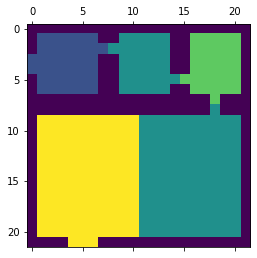

In [477]:
list_nodes = list(G.nodes())
map_clustered = np.zeros_like(np_map)

for idx, cluster_nodes in enumerate(clusters):
    for node in cluster_nodes:
        i, _ = np.where(np.isclose(W, node).all(axis=1))
        (y,x) = list_nodes[i[0]]
        map_clustered[y,x] = idx + 1

plt.matshow(map_clustered, cmap='viridis', interpolation='nearest')
plt.show()
